In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import time, pickle, warnings, json, os
from datetime import datetime
warnings.filterwarnings("ignore")

shuffle = True

## Train parameter

In [2]:
root = os.getcwd()
input_ = {
   "START_DATE": "2022-05-25",
   "END_DATE": datetime.today().strftime("%Y-%m-%d"),
   "INIT_PATH": os.path.join(root, "data/init"),
   "TRAIN_LOG": os.path.join(root, "prog/logs/train.log"),
   "MODEL_PATH":  os.path.join(root, "data/models", str(datetime.timestamp(datetime.now()))),
}

In [ ]:
start = input_["START_DATE"]
end = input_["END_DATE"]
init_path = input_["INIT_PATH"]
model_path = input_["MODEL_PATH"]

start = datetime.strptime(start, "%Y-%m-%d")
end = datetime.strptime(end, "%Y-%m-%d")

if not os.path.isdir(model_path):
    os.makedirs(model_path)
    
model_detail = os.path.join(model_path, "model")
if not os.path.isdir(model_detail):
    os.makedirs(model_detail)

start, end, init_path, model_path, model_detail

## Data Loading

In [4]:
df0 = pd.DataFrame()
for dirs1 in os.listdir(init_path):
    if (int(dirs1) < start.year) or (int(dirs1) > end.year):
        continue

    for dirs2 in os.listdir(os.path.join(init_path, dirs1)): # dir - month
        if ((int(dirs1) <= start.year) & (int(dirs2) < start.month)) or ((int(dirs1) >= end.year) & (int(dirs2) > end.month)):
            continue
        
        for dirs3 in os.listdir(os.path.join(init_path, dirs1, dirs2)): # dir - day
            date = datetime.strptime(dirs3[:-4], "%Y%m%d")
            if (date < start) or (date > end):
                continue

            path = os.path.join(init_path, dirs1, dirs2, dirs3)
            df1 = pd.read_csv(path)
            df0 = pd.concat([df0, df1], ignore_index = True)

print(f"data shape: {df0.shape}")
df0["time"] = pd.to_datetime(df0["time"])
df0 = df0.sort_values("time")

data shape: (36339, 32)


In [5]:
# column加密
col = {df0.columns[i]: i for i in range(df0.shape[1])}
df0.columns =  [f"{i}" for i in range(df0.shape[1])]
df0.head(3)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,2022-05-25 14:06:00,0.987,43.7,100.0,163.3,-32.3,-40.4,-36.3,93.0,79.4,...,91.0,83.0,0.7,13.0,-51.6,-51.6,100.0,73.1,13.3,2.4
1,2022-05-25 14:07:00,0.993,43.7,100.0,163.2,-32.5,-40.4,-36.4,93.0,79.1,...,91.0,83.0,0.7,13.2,-51.6,-51.6,100.0,73.4,13.3,2.4
2,2022-05-25 14:08:00,0.989,43.8,101.0,162.9,-32.7,-40.3,-36.5,93.0,78.7,...,91.0,83.2,0.7,13.4,-51.5,-51.5,100.0,73.4,13.3,2.4


#### Select Features and Target

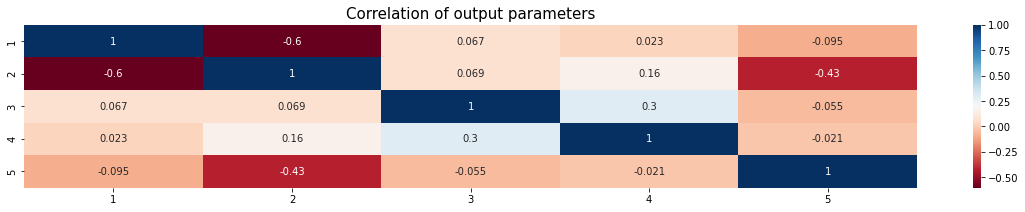

In [6]:
plt.figure(figsize=(20, 3))
sns.heatmap(data = df0.iloc[:, 1:6].corr(), annot=True, cmap = 'RdBu')
plt.title('Correlation of output parameters', fontsize = 15)
# plt.xticks(rotation = 15)
plt.show()

In [7]:
target = "2"
features = df0.columns[5:].to_list()

In [8]:
df = df0.copy()
df = df.set_index("0")
df = df[[target] + features]
print(f"data shape: {df.shape}")
df.head(3)

data shape: (36339, 28)


,2,5,6,7,8,9,10,11,12,13,...,22,23,24,25,26,27,28,29,30,31
0,,,,,,,,,,,,,,,,,,,,,
2022-05-25 14:06:00,43.7,-32.3,-40.4,-36.3,93.0,79.4,12.2,5.6,-49.0,-61.9,...,91.0,83.0,0.7,13.0,-51.6,-51.6,100.0,73.1,13.3,2.4
2022-05-25 14:07:00,43.7,-32.5,-40.4,-36.4,93.0,79.1,11.8,5.6,-49.0,-61.8,...,91.0,83.0,0.7,13.2,-51.6,-51.6,100.0,73.4,13.3,2.4
2022-05-25 14:08:00,43.8,-32.7,-40.3,-36.5,93.0,78.7,11.8,5.6,-49.0,-61.8,...,91.0,83.2,0.7,13.4,-51.5,-51.5,100.0,73.4,13.3,2.4


### Slide window 10 min

In [9]:
# 補上缺失的時間段
time_ = pd.date_range(df.index[0], df.index[-1], freq = "min").to_frame(name = "time")
df = pd.merge(df, time_, left_index = True, right_index = True, how = "right")

In [10]:
# 每十分鐘取平均
df = df.rolling(10).mean()
df = df.dropna()
df.shape

(36069, 28)

#### Drop data leackage

In [11]:
import numpy as np
from tqdm import tqdm

In [12]:
#該筆資料和前一筆資料的距離
distance = [None]
for i in tqdm(range(1, len(df))):
    distance.append(np.linalg.norm(df.iloc[i].values - df.iloc[i-1].values))
df["distance"] = distance
df.head(3)

100%|██████████| 36068/36068 [00:12<00:00, 2838.21it/s]


,2,5,6,7,8,9,10,11,12,13,...,23,24,25,26,27,28,29,30,31,distance
2022-05-25 14:15:00,43.73,-32.59,-40.31,-36.45,93.0,79.10,11.92,5.73,-48.99,-61.78,...,83.42,0.7,13.26,-51.55,-51.55,100.0,73.34,13.3,2.42,NaN
2022-05-25 14:16:00,43.72,-32.57,-40.30,-36.44,93.0,79.15,11.89,5.73,-48.99,-61.77,...,83.49,0.7,13.29,-51.54,-51.54,100.0,73.37,13.3,2.42,0.111803
2022-05-25 14:17:00,43.71,-32.53,-40.29,-36.42,93.0,79.20,11.93,5.73,-48.99,-61.77,...,83.51,0.7,13.31,-51.54,-51.54,100.0,73.36,13.3,2.42,0.088318


In [13]:
df["distance"].describe()

count    36068.000000
mean         0.438379
std          1.661526
min          0.000000
25%          0.090554
50%          0.132288
75%          0.222036
max         45.337812
Name: distance, dtype: float64

In [14]:
# 距離小於中位數的sample刪除
median = df["distance"].median()
df = df.query("distance >= @median")
df = df.drop("distance", axis = 1)
df.shape

(18035, 28)

## EDA & Feature Engineering

#### Basic information

In [15]:
df.info()
# 沒有類別變數

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18035 entries, 2022-05-25 14:18:00 to 2022-08-24 23:54:00
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2       18035 non-null  float64
 1   5       18035 non-null  float64
 2   6       18035 non-null  float64
 3   7       18035 non-null  float64
 4   8       18035 non-null  float64
 5   9       18035 non-null  float64
 6   10      18035 non-null  float64
 7   11      18035 non-null  float64
 8   12      18035 non-null  float64
 9   13      18035 non-null  float64
 10  14      18035 non-null  float64
 11  15      18035 non-null  float64
 12  16      18035 non-null  float64
 13  17      18035 non-null  float64
 14  18      18035 non-null  float64
 15  19      18035 non-null  float64
 16  20      18035 non-null  float64
 17  21      18035 non-null  float64
 18  22      18035 non-null  float64
 19  23      18035 non-null  float64
 20  24      18035 non-null  float64
 21  

In [16]:
df.describe().T
# fearure包含負數，轉換時須注意

,count,mean,std,min,25%,50%,75%,max
2,18035.0,36.487776,12.083276,0.00,37.900,40.64,42.46,4.670000e+01
5,18035.0,-33.236051,6.948868,-42.86,-37.250,-35.57,-29.84,-1.000000e-01
6,18035.0,-34.556000,6.327335,-41.04,-38.065,-35.94,-32.81,4.000000e-01
7,18035.0,-33.896266,5.894536,-40.38,-36.750,-34.88,-32.82,1.200000e-01
8,18035.0,87.743097,7.324414,50.00,85.000,89.00,92.00,9.500000e+01
9,18035.0,70.076419,13.021604,0.30,63.235,69.89,78.16,1.011000e+02
10,18035.0,15.865579,2.406720,0.50,14.190,16.61,17.69,2.227000e+01
11,18035.0,7.654553,2.252182,0.40,6.410,7.34,8.29,2.885000e+01
12,18035.0,-41.480476,9.984695,-50.55,-49.660,-48.78,-34.68,5.000000e-01
13,18035.0,-55.180003,10.536119,-63.62,-62.360,-61.62,-49.88,-3.600000e-01


In [17]:
df.isnull().sum().sum()
# 無 missing value

0

#### Target Analysis

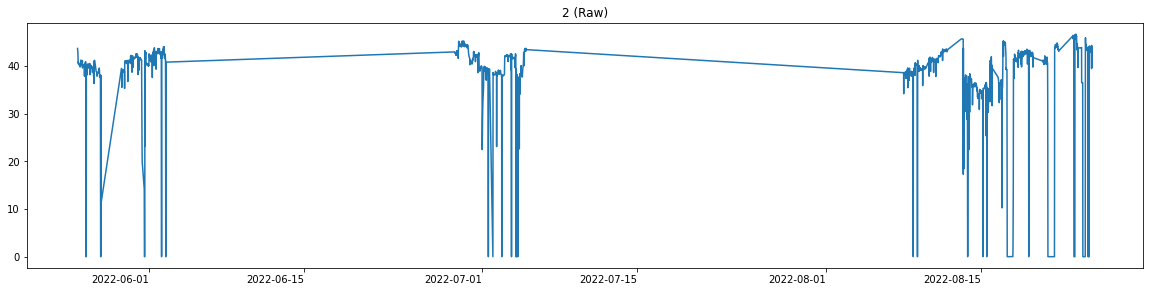

In [18]:
plt.figure(figsize=(20, 5)) 
df[target].plot()
plt.title(f'{target} (Raw)')
plt.xticks(rotation=0)
plt.show()
#正常Y應該要在40上下，Target有許多異常狀態，須砍掉異常sample

In [19]:
#Target異常狀態處理
df = df[(df[target] > 25)]
df.shape

(16077, 28)

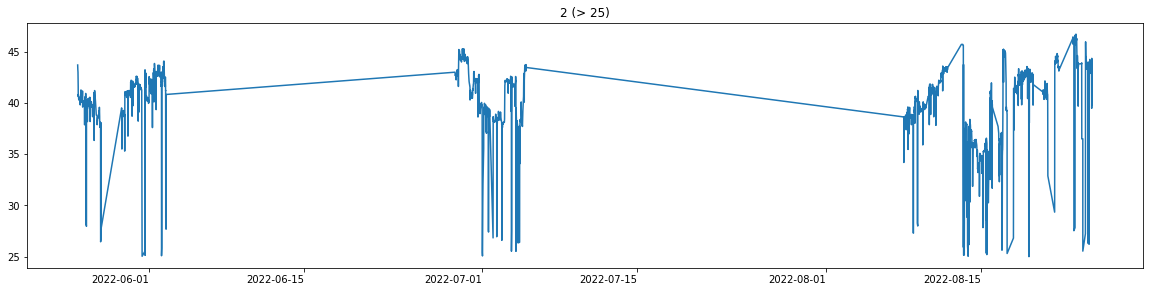

In [20]:
plt.figure(figsize=(20, 5)) 
df[target].plot()
plt.title(f'{target} (> 25)')
plt.xticks(rotation=0)
plt.show()

#### Correlation

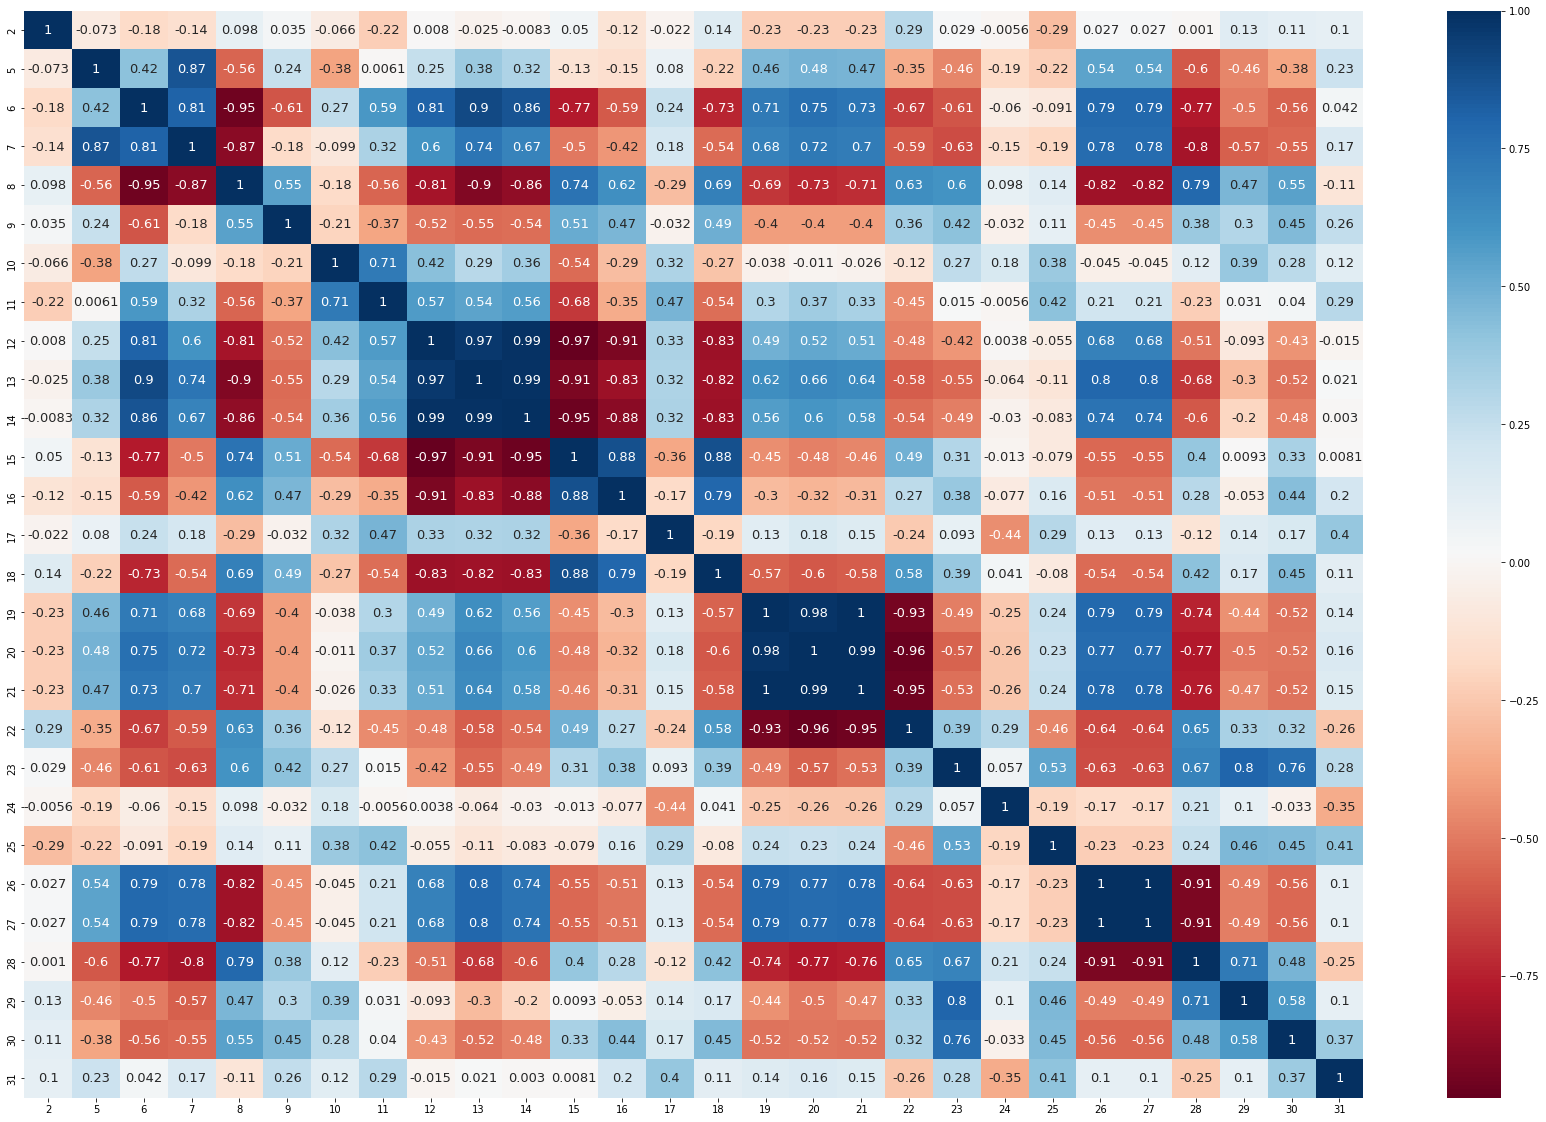

In [21]:
plt.figure(figsize=(30, 20))
sns.heatmap(data = df.corr(), annot=True, cmap = 'RdBu', annot_kws = {"fontsize": 13})
plt.show()

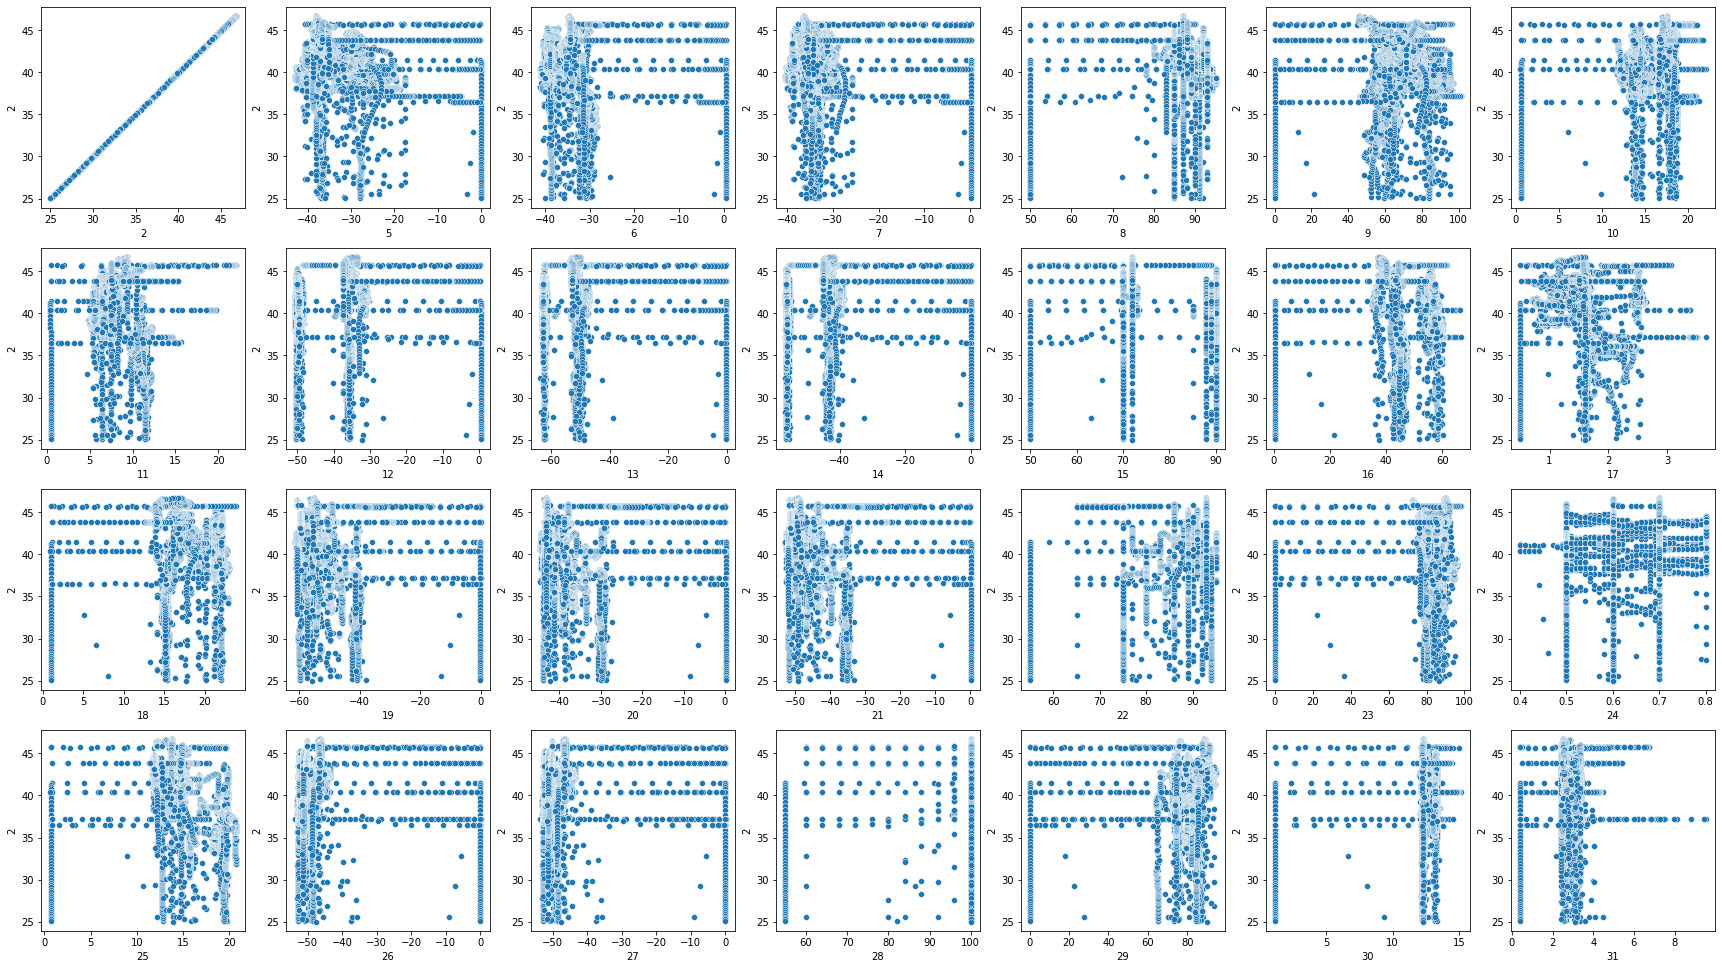

In [22]:
# "Relationship between features and target"
k = 0
a, b = 4, 7
fig, ax = plt.subplots(a, b, figsize = (30, 17))
for i in range(a):
    for j in range(b):
        sns.scatterplot(x = df.columns[k], y = target, data = df, ax = ax[i, j])
        k += 1
plt.show()


#### Split train、test data

In [23]:
train, test = train_test_split(df, test_size = 0.2, shuffle = shuffle)
print(f"train shape: {train.shape} 、 test shape: {test.shape}")

train shape: (12861, 28) 、 test shape: (3216, 28)


#### Feature Analysis

In [24]:
train1, test1 = train.copy(), test.copy()
train1, valid1 = train_test_split(train1, test_size = 0.2, shuffle = shuffle)
train1, valid1, test1 = train1.sort_index(), valid1.sort_index(), test1.sort_index()
print(train1.shape, valid1.shape, test1.shape)

(10288, 28) (2573, 28) (3216, 28)


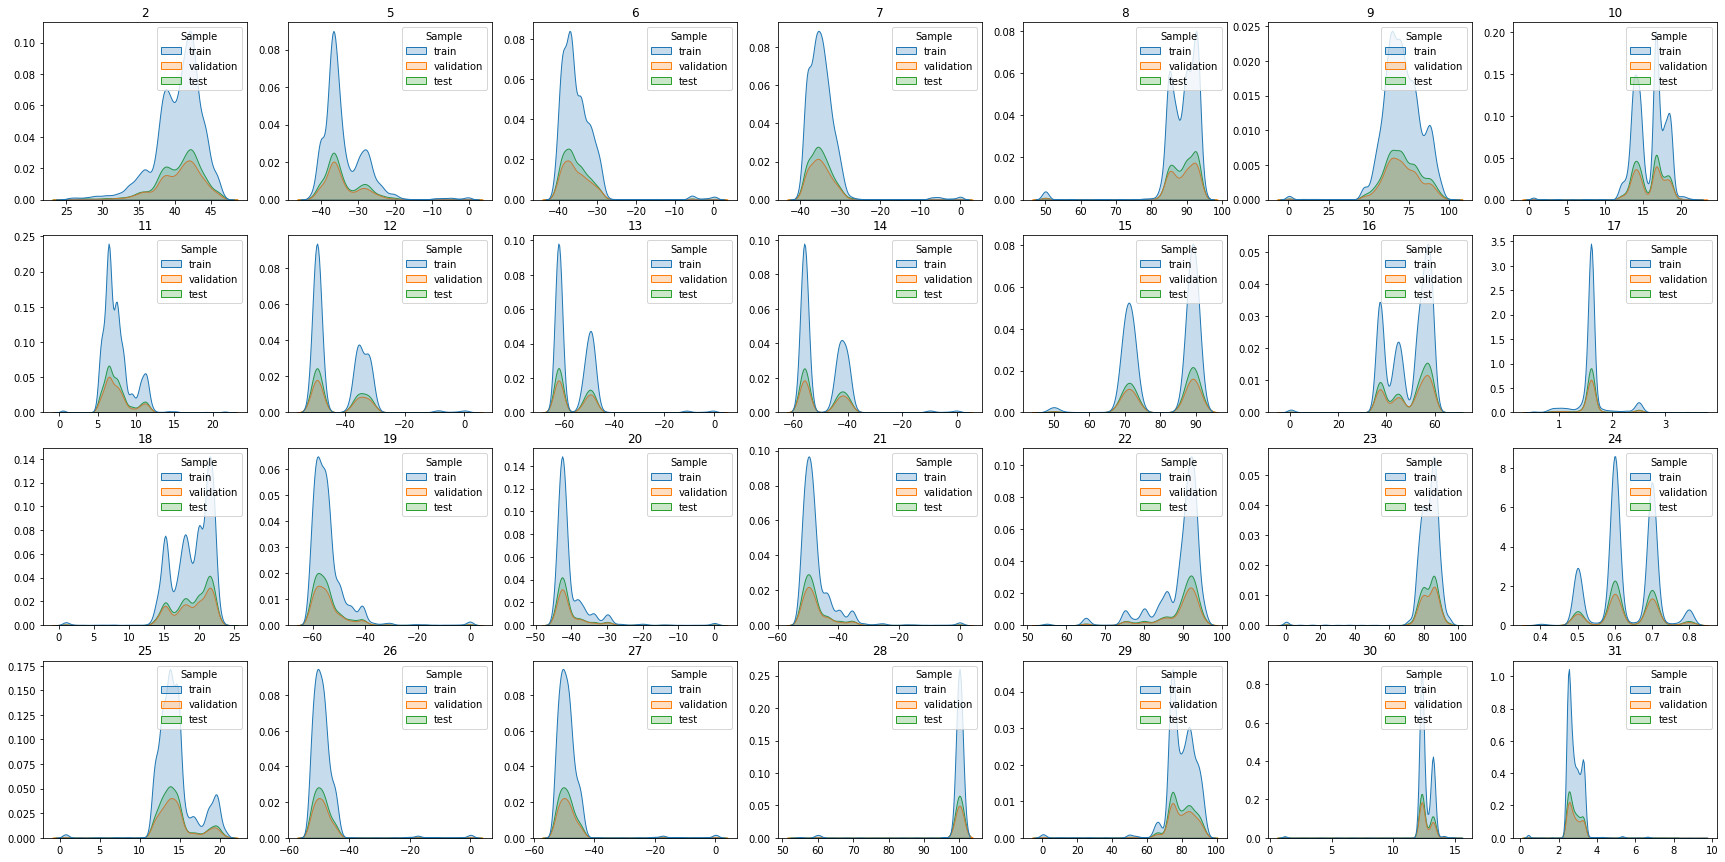

In [25]:
train2, valid2, test2 = train1.copy(), valid1.copy(), test1.copy()
train2["Sample"], valid2["Sample"], test2["Sample"] = "train", "validation", "test"
data = pd.concat([train2, valid2, test2])

k = 0
a, b = 4, 7
fig, ax = plt.subplots(a, b, figsize = (30, 15))
for i in range(a):
    for j in range(b):
        sns.kdeplot(data = data, x = data.columns[k], hue = "Sample", shade=True, ax = ax[i, j])
        ax[i, j].set(ylabel = None, xlabel = None, title = data.columns[k])
        k += 1
# 分佈相近

In [ ]:
a, b = len(train1.columns), 1
k = 0
fig, ax = plt.subplots(a, b, figsize = (20, 110))
for i in range(a):
    ax[i].plot(train1[train1.columns[k]])
    ax[i].plot(valid1[valid1.columns[k]])
    ax[i].plot(test1[test1.columns[k]])
    ax[i].set_title(train1.columns[k])
    ax[i].legend(["train", "validation", "test"], fontsize = 11) 
    k += 1

#### Outlier

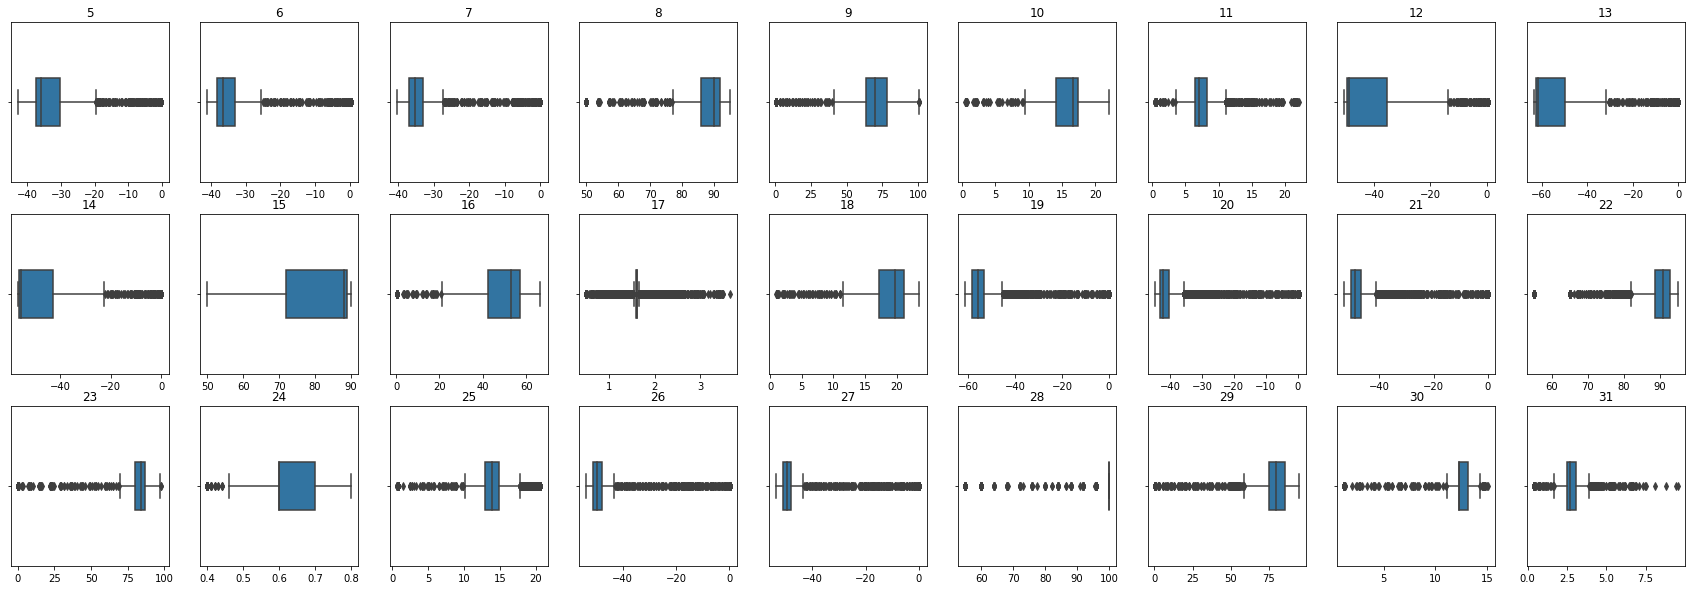

In [27]:
a, b = 3, 9
k = 0
fig, ax = plt.subplots(a, b, figsize = (30, 10))
for i in range(a):
    for j in range(b):
        sns.boxplot(x = features[k], data = train, width = 0.3, ax = ax[i, j])
        ax[i, j].set(xlabel = None, ylabel = None, title = features[k])
        k += 1

In [28]:
outlier_boundary = {}
for col in features:
    Q1   = train[col].quantile(0.25)
    Q3   = train[col].quantile(0.75)
    IQR  = Q3 - Q1
    min_ = Q1 - (1.5 * IQR)
    max_ = Q3 + (1.5 * IQR)
    
    train[col] = train[col].apply(lambda X: max_ if X > max_ else X)
    train[col] = train[col].apply(lambda X: min_ if X < min_ else X)

    test[col] = test[col].apply(lambda X: max_ if X > max_ else X)
    test[col] = test[col].apply(lambda X: min_ if X < min_ else X)

    outlier_boundary[col] = {
        "min": min_,
        "max": max_,
    }

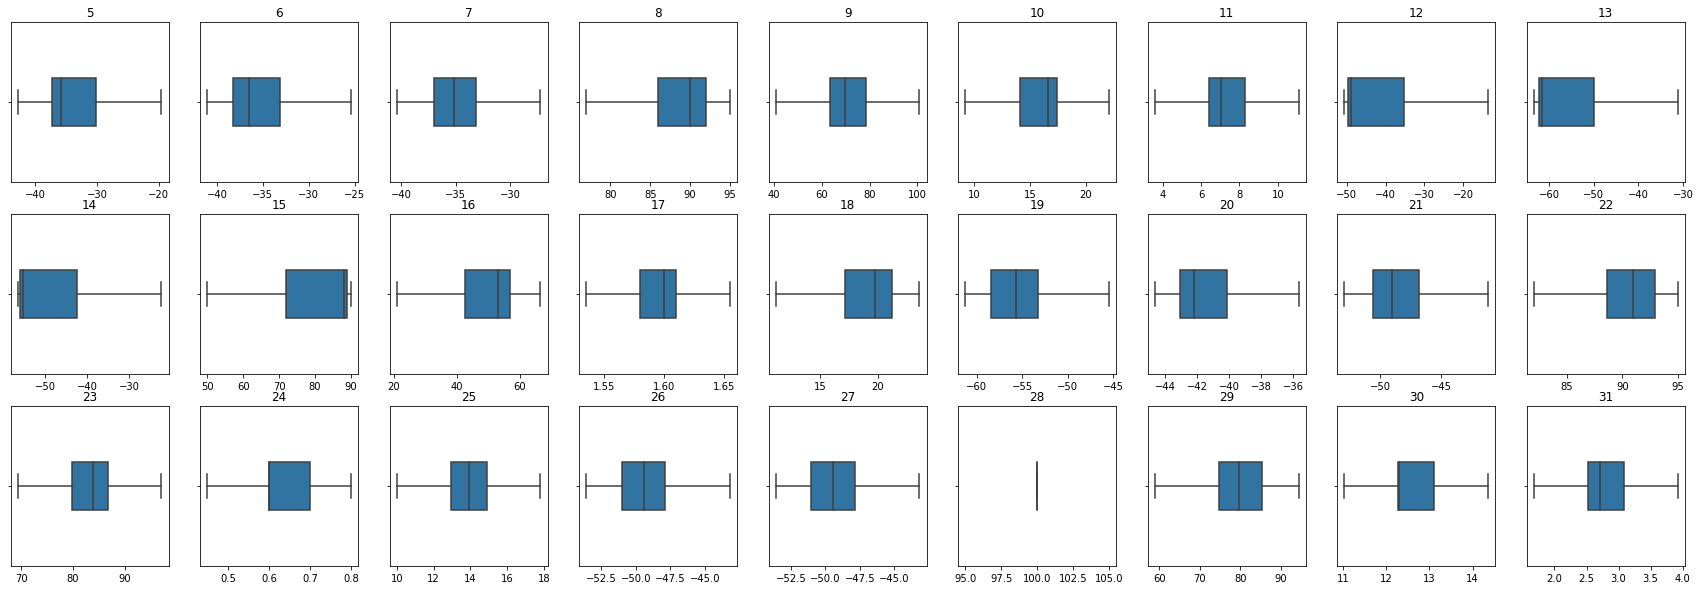

In [29]:
a, b = 3, 9
k = 0
fig, ax = plt.subplots(a, b, figsize = (30, 10))
for i in range(a):
    for j in range(b):
        sns.boxplot(x = features[k], data = train, width = 0.3, ax = ax[i, j])
        ax[i, j].set(xlabel = None, ylabel = None, title = features[k])
        k += 1

In [30]:
train.to_csv(f"{model_detail}\\preprocess.csv", index = False)

#### Skew

In [31]:
skewness = train[features].apply(lambda X: skew(X)).sort_values(ascending=False)
skewness = pd.DataFrame({'Feature' : skewness.index, 'Skew' : skewness.values})
skewness = skewness.query("(Skew > 0.75) | (Skew < -0.75)")
skewness = skewness.reset_index(drop = True)
skewness

,Feature,Skew
0,20,1.080605
1,13,0.980819
2,5,0.980560
3,21,0.905001
4,14,0.894492
5,11,0.861118
6,19,0.846021
7,12,0.805904
8,6,0.778187
9,8,-0.784052


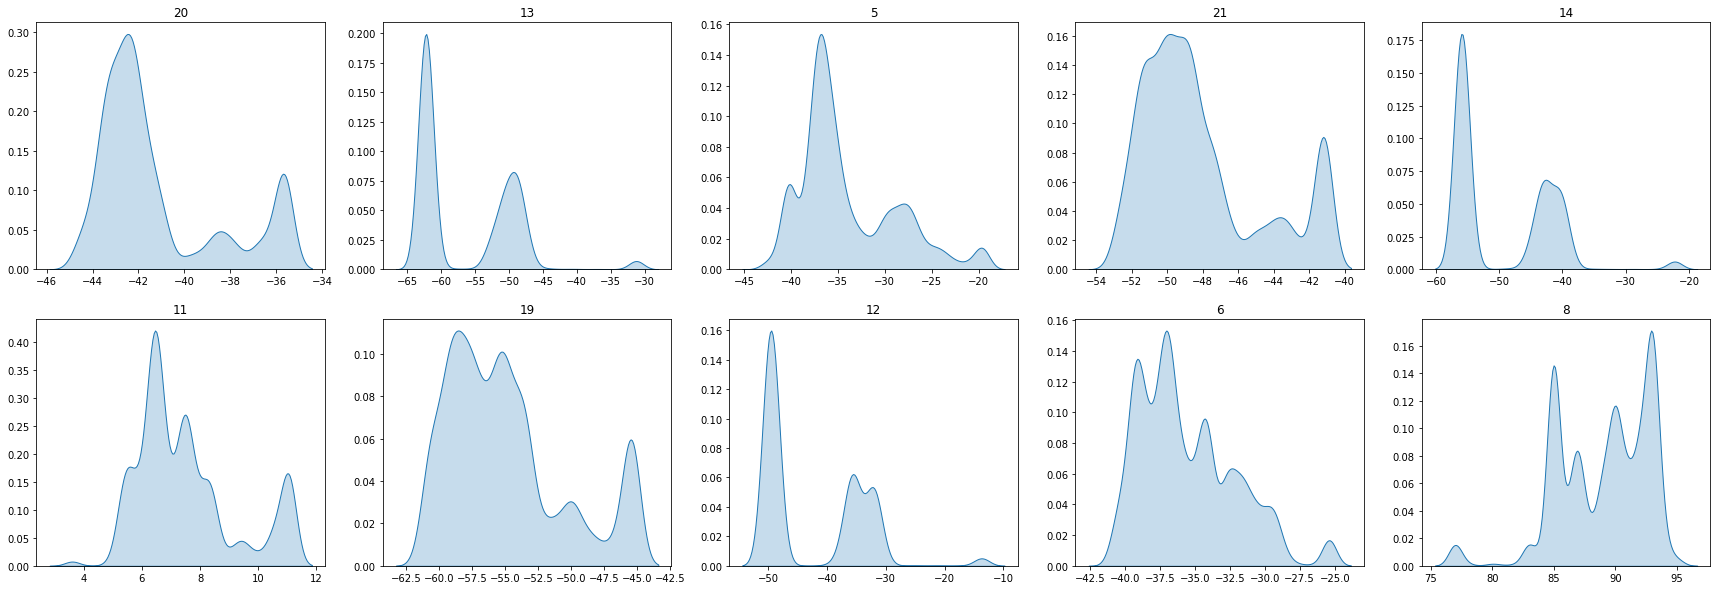

In [32]:
a, b = 2, 5
k = 0
fig, ax = plt.subplots(a, b, figsize = (30, 10))
for i in range(a):
    for j in range(b):
        sns.kdeplot(data = train, x = skewness["Feature"].iloc[k], shade=True, ax = ax[i, j])
        ax[i, j].set(ylabel = None, xlabel = None, title = skewness["Feature"].iloc[k])
        k += 1
        if k >= len(skewness):
            break

In [33]:
pt = PowerTransformer(method = 'yeo-johnson')
train[skewness["Feature"]] = pt.fit_transform(train[skewness["Feature"]])

In [34]:
test[skewness["Feature"]] = pt.transform(test[skewness["Feature"]])

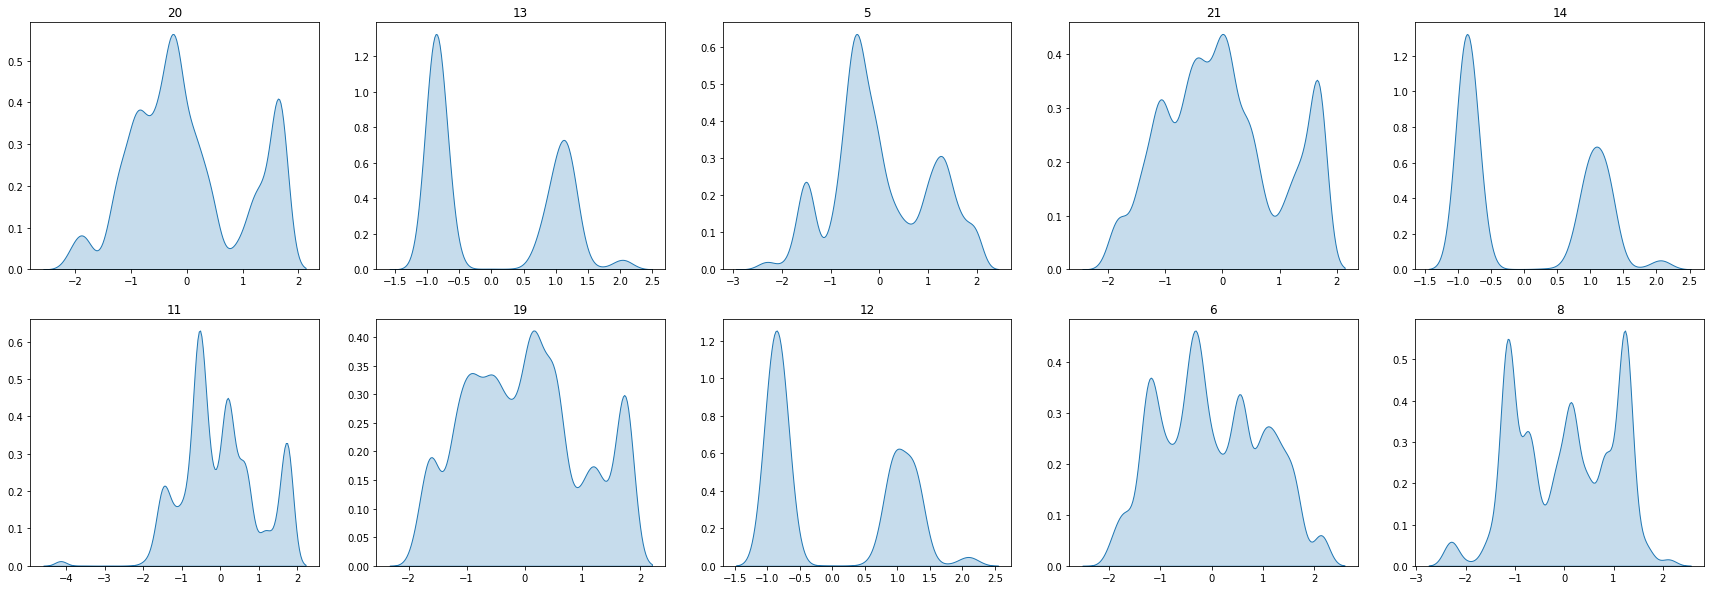

In [35]:
a, b = 2, 5
k = 0
fig, ax = plt.subplots(a, b, figsize = (30, 10))
for i in range(a):
    for j in range(b):
        sns.kdeplot(data = train, x = skewness["Feature"].iloc[k], shade=True, ax = ax[i, j])
        ax[i, j].set(ylabel = None, xlabel = None, title = skewness["Feature"].iloc[k])
        k += 1
        if k >= len(skewness):
            break

#### Scaling

In [36]:
scaler = StandardScaler()
train[features] = scaler.fit_transform(train[features])

In [37]:
test[features] = scaler.transform(test[features])

## Modeling

#### Split data

In [38]:
train_data, test_data = train, test
train_data, valid_data = train_test_split(train_data, test_size = 0.3, shuffle = shuffle)
print(train_data.shape, valid_data.shape, test_data.shape)

(9002, 28) (3859, 28) (3216, 28)


### ML model

In [39]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

random_state = 99#None
models = {
    "                     Linear Regression": LinearRegression(),
    " Linear Regression (L2 Regularization)": Ridge(),
    " Linear Regression (L1 Regularization)": Lasso(),
    "                   K-Nearest Neighbors": KNeighborsRegressor(),
    "                        Neural Network": MLPRegressor(),
    "Support Vector Machine (Linear Kernel)": LinearSVR(),
    "   Support Vector Machine (RBF Kernel)": SVR(),
}
feat = features
X_train, y_train = train[feat], train[target]
X_test, y_test = test[feat], test[target]
for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained.")

                     Linear Regression trained.
 Linear Regression (L2 Regularization) trained.
 Linear Regression (L1 Regularization) trained.
                   K-Nearest Neighbors trained.
                        Neural Network trained.
Support Vector Machine (Linear Kernel) trained.
   Support Vector Machine (RBF Kernel) trained.


In [40]:
from sklearn.model_selection import ShuffleSplit, cross_val_score
train_test_flag = 1
cv_flag = 0
score = []
for key, model in models.items():
    print(key)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    train_mse  = mean_squared_error(y_train, train_pred).round(2)
    test_mse   = mean_squared_error(y_test, test_pred).round(2)
    train_rmse =  (train_mse ** (1/2)).round(2)
    test_rmse  =  (test_mse ** (1/2)).round(2)
    train_mape = mean_absolute_percentage_error(train_pred, y_train)
    test_mape = mean_absolute_percentage_error(test_pred, y_test)
    train_r2   = r2_score(train_pred, y_train).round(2)
    test_r2    = r2_score(test_pred, y_test).round(2)


    if train_test_flag:
        col1 = [train_mse, test_mse, train_rmse, test_rmse, train_mape, test_mape, train_r2, test_r2]
        col2 = ["MSE_train", "MSE_test", "RMSE_train", "RMSE_test", "MAPE_train", "MAPE_test", "R2_train", "R2_test"]
    else:
        col1 = [test_mse, test_rmse, test_mape, test_r2]
        col2 =  ["MSE_test", "RMSE_test", "MAPE_test", "R2_test"]
    

    if cv_flag:
        # cv = ShuffleSplit(n_splits = 3, test_size = 0.2)
        cv_scores = cross_val_score(model, X_train, y_train, cv = 5)
        cv_score = cv_scores.mean().round(2)
        col1 += [cv_score]
        col2 += ["R2_cv"]
    
    score.append(col1)


index  = [i.lstrip() for i in models.keys()]
score  = pd.DataFrame(score, index = index, columns = col2)
score

                     Linear Regression
 Linear Regression (L2 Regularization)
 Linear Regression (L1 Regularization)
                   K-Nearest Neighbors
                        Neural Network
Support Vector Machine (Linear Kernel)
   Support Vector Machine (RBF Kernel)


,MSE_train,MSE_test,RMSE_train,RMSE_test,MAPE_train,MAPE_test,R2_train,R2_test
Linear Regression,6.16,6.32,2.48,2.51,0.041494,0.041620,-0.36,-0.41
Linear Regression (L2 Regularization),6.21,6.34,2.49,2.52,0.041430,0.041501,-0.39,-0.44
Linear Regression (L1 Regularization),10.45,10.78,3.23,3.28,0.060625,0.061630,-701.73,-739.45
K-Nearest Neighbors,0.67,1.07,0.82,1.03,0.005605,0.007441,0.93,0.89
Neural Network,2.08,2.34,1.44,1.53,0.020624,0.021273,0.76,0.73
Support Vector Machine (Linear Kernel),7.04,7.07,2.65,2.66,0.039070,0.039140,-0.42,-0.47
Support Vector Machine (RBF Kernel),2.77,2.99,1.66,1.73,0.017478,0.018138,0.59,0.55


### DL model

#### Select device

In [41]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)

#### DataFrame transform to Torch Dataset

In [42]:
class Dataset_transform(Dataset):
    def __init__(self, df, features, target):
        self.n_samples = len(df)
        self.X = torch.Tensor(df[features].values)#.to(device)
        self.y = torch.Tensor(df[target].values.reshape(-1, 1))#.to(device)
                                            
    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [43]:
train_dataset = Dataset_transform(train_data, features, target)
valid_dataset = Dataset_transform(valid_data, features, target)
test_dataset = Dataset_transform(test_data, features, target)

#### DataLoader to use for batch

In [44]:
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = len(valid_dataset))
test_dataloader = DataLoader(test_dataset, batch_size = len(test_dataset))

#### Model structure

In [45]:
class Model(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net  = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 32),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 1),
        )
    
    def forward(self, x):
        x = self.net(x)
        return x

In [46]:
epochs = 500
model = Model(input_size = len(features))#.to(device)
criterion = nn.MSELoss()#.to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

#### Initialize weights

In [47]:
# 初始化權重，使其符合常態分布
for m in model.modules():
    if isinstance(m, (nn.Linear)):
        nn.init.kaiming_normal_(m.weight)

#### Training model

In [48]:
# validate、test預測後的損失函數，以及相關分數
def eval_score(dataloader, model, criterion, mode = "eval"):
    model.eval()
    losses = 0
    pred1, y1 = torch.Tensor([]), torch.Tensor([])
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X) #預測
        loss = criterion(pred, y) #計算損失函數
        losses += loss.item()

        # pred, y = pred.cpu(), y.cpu()
        pred1 = torch.concat([pred1, pred])
        y1 = torch.concat([y1, y])

    losses /= (batch + 1)

    if mode == "train":
        return losses
        
    pred1 = pred1.detach().numpy()
    y1 = y1.detach().numpy()
    MSE = mean_squared_error(pred1, y1)
    RMSE = MSE ** (1/2)
    MAPE = mean_absolute_percentage_error(pred1, y1)
    R2 = r2_score(pred1, y1)
    
    return MSE, RMSE, MAPE, R2, pred1, y1

In [ ]:
# 建模
best_loss = np.inf
paitence = 30
train_losses = []
valid_losses = []
for epoch in range(epochs):
    train_loss = 0
    valid_loss = 0
    # train model
    model.train() # 模型為訓練模式
    for batch, (X_train, y_train) in enumerate(train_dataloader):
        train_pred = model(X_train) #預測
        loss = criterion(train_pred, y_train) #計算損失函數

        optimizer.zero_grad() # 梯度在反向傳播前先清零
        loss.backward() # 反向傳播，計算權重對損失函數的梯度
        optimizer.step()  # 根據梯度更新權重
        train_loss += loss.item()
    train_loss /= (batch + 1)
    train_losses.append(train_loss)

    # validate model
    model.eval()# 模型為評估模式
    valid_loss = eval_score(valid_dataloader, model, criterion, mode = "train")
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch} - train_loss: {train_loss:.4f},  valid_loss: {valid_loss:.4f}")

    # 損失函數連續30個epoches都沒下降的話就終止訓練
    if valid_loss < best_loss:
        best_loss = valid_loss
        remain_patience = paitence
    else:
        remain_patience -= 1
        if remain_patience == 0:
            print('early stop!')
            break
print("Done!")

#### Predict

In [50]:
data_name = ["Train", "Validation", "Test"]
dataloaders = [train_dataloader, valid_dataloader, test_dataloader]
score = pd.DataFrame(columns = ["MSE", "RMSE", "MAPE", "R2"])
result = {}

for name, dataloader in zip(data_name, dataloaders):
    MSE, RMSE, MAPE, R2, pred, true = eval_score(dataloader, model, criterion)
    score.loc[name] = [MSE, RMSE, MAPE, R2]
    result[name] = {
        "true": true.reshape(-1),
        "pred": pred.reshape(-1),
    }

train_result = pd.DataFrame(result["Train"], index = train_data.index).sort_index()
valid_result = pd.DataFrame(result["Validation"], index = valid_data.index).sort_index()
test_result = pd.DataFrame(result["Test"], index = test_data.index).sort_index()

score["COUNT"] = [len(train_data), len(valid_data), len(test_data)]
score = score.round(4)
score

,MSE,RMSE,MAPE,R2,COUNT
Train,1.3686,1.1699,0.0158,0.8552,9002
Validation,1.7875,1.3370,0.0167,0.8072,3859
Test,1.8737,1.3688,0.0173,0.7974,3216


In [51]:
with open(f'{model_path}/train.json', 'w') as f:
    json.dump(score.to_dict(), f)

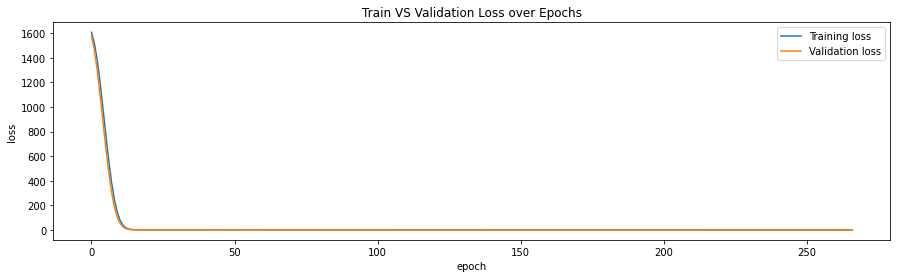

In [52]:
plt.figure(figsize=(15, 4))
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.title("Train VS Validation Loss over Epochs")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.savefig(f"{model_path}/chart.png")

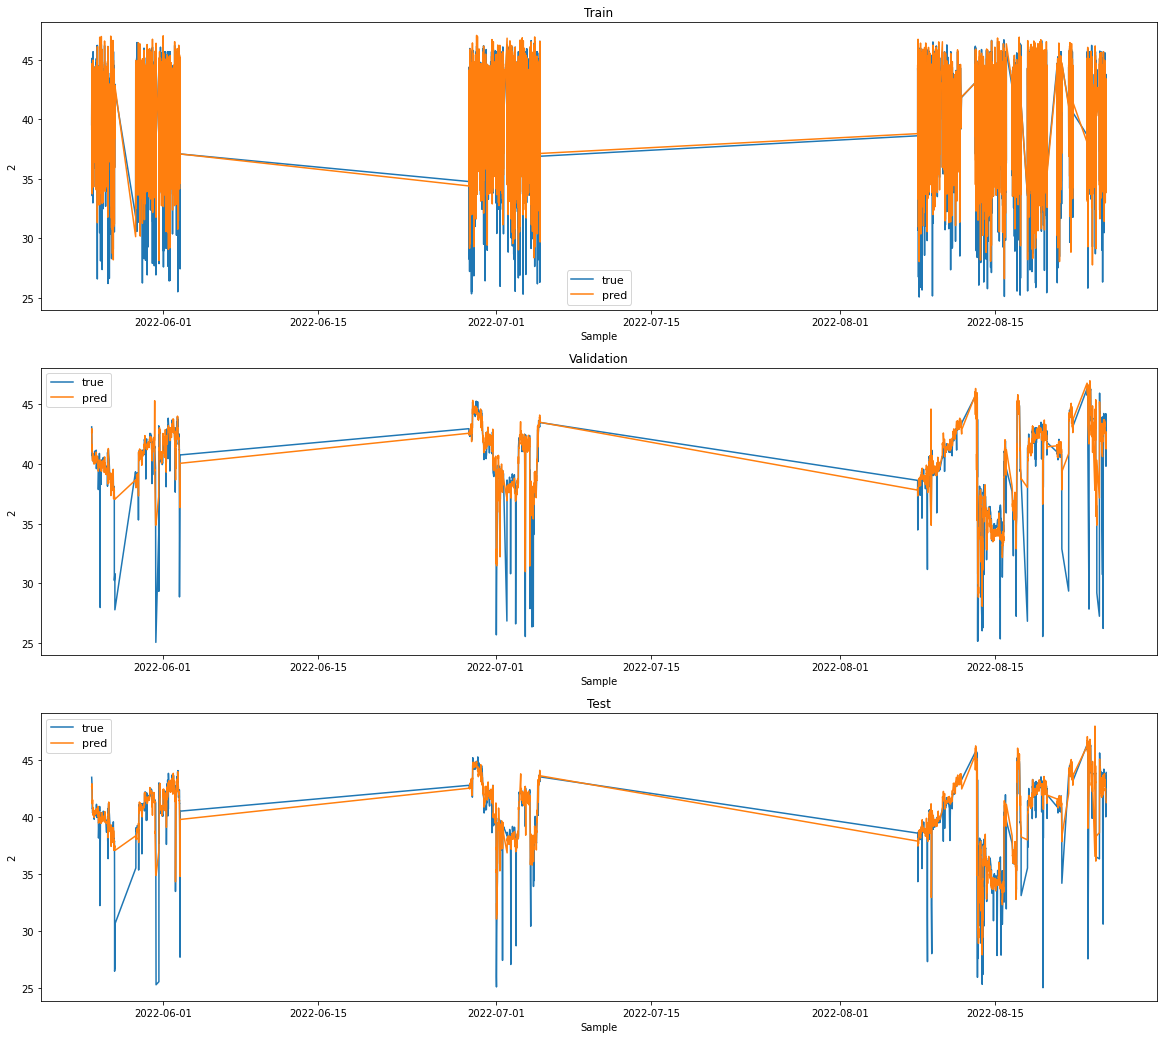

In [53]:
data = [train_result, valid_result, test_result]
fig, ax = plt.subplots(3, 1, figsize = (20, 18))
for i in range(3):
    ax[i].plot(data[i])
    ax[i].set(ylabel = target, xlabel = "Sample", title = data_name[i])
    ax[i].legend(["true", "pred"], fontsize = 11)
fig.savefig(f"{model_path}/pred.png")

## Save

In [54]:
# 儲存model
pickle.dump(features, open(f'{model_detail}/feat_order.pkl','wb'))
skew_feat = [list(train.columns[1:]).index(skewness["Feature"][i]) for i in range(len(skewness["Feature"]))]
pickle.dump(skew_feat, open(f'{model_detail}/skew_feat.pkl','wb'))
pickle.dump(outlier_boundary, open(f'{model_detail}/outlier_boundary.pkl','wb'))
pickle.dump(pt, open(f'{model_detail}/power_tf.pkl','wb'))
pickle.dump(scaler, open(f'{model_detail}/scaler.pkl','wb'))
torch.save(model.state_dict(), f"{model_detail}/nn_weights.pt") # 儲存權重

In [55]:
# 抓出產出超過40的sample的所有feature之四分位數
df1 = pd.read_csv(f"{model_detail}/preprocess.csv")
df40 = df1[(df1[target] >= 40)][features]
df40_range = df40.describe().T[["25%", "50%", "75%", "max"]]
df40_range = df40_range.reset_index()
df40_range = df40_range.rename(columns = {"index": "feature"})
df40_range.to_csv(f"{model_detail}/output40.csv", index = False)

In [56]:
# 前端的預設參數
df40_range = df40_range.set_index("feature")
df40_range.columns = ["q1", "q2", "q3", "q4"]

with open(f'{model_path}/parameter.json', 'w') as f:
    json.dump(df40_range.T.to_dict(), f)

## Input X optimize

### Predict parameter

In [ ]:
root = os.getcwd()
models = os.listdir(os.path.join(root, "data", "models"))
model_time = sorted(models)[-1]
model_path = os.path.join(root, "data", "models", str(model_time))
print(f"The path of latest model is {model_path}.")

In [ ]:
predict_path = os.path.join(root, "data", "predictions", str(datetime.timestamp(datetime.now())))
if not os.path.isdir(predict_path):
    os.makedirs(predict_path)
predict_path

In [47]:
# input X
import random

target = "Hourly_Production"

# 輸入參數
df0 = pd.read_csv(os.path.join(root, "data", "data.csv"))
features = df0.columns[5:].to_list()
df_lower40 = df0[(df0[target] < 40)][target]#.iloc[-3:-2]
ind = random.choice(df_lower40.index)
output = df0.loc[ind, target]
X0 = df0.iloc[ind: ind+1][features]

# 指定不可調動的參數
fixed_mask = [random.randint(0, 1) for i in range(27)]

print("initial X =", X0.values)
print("fixed mask =", fixed_mask)
print("output = ", output)


# 轉為實際輸入的input格式
input_data = {X0.columns[i]: {"init": X0.values[0][i], "fixed": random.randint(0, 1)} for i in range(X0.shape[1])}
input_data[target]= {"init": 41}

with open(f'{predict_path}/input.json', 'w') as f:
    json.dump(input_data, f)

initial X = [[-37.7 -31.  -34.4  87.   64.9  17.1  10.  -35.6 -50.3 -42.9  70.   44.4
    1.6  15.9 -57.1 -41.2 -49.1  89.   84.4   0.7  14.7 -50.9 -50.9 100.
   74.9  12.8   2.5]]
fixed mask = [1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0]
output =  37.7


In [ ]:
input_ = {
    "INPUT": os.path.join(predict_path, "input.json"),
    "MODEL": model_path,
    "OUTPUT": os.path.join(predict_path, "output.json"),
    "LOG": os.path.join(root, "prog", "logs", "predict.log"),
    }
input_

In [ ]:
input_path = input_["INPUT"]
output_path = input_["OUTPUT"]
model_detail = os.path.join(input_["MODEL"], "model")
log_path = input_["LOG"]
pred_path = os.path.dirname(input_path)
input_path, model_detail, output_path, log_path, pred_path

#### Load model

In [50]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.net  = nn.Sequential(
            nn.Linear(27, 32),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 32),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 1),
        )
    
    def forward(self, x):
        x = self.net(x)
        return x

In [51]:
# 載入訓練好的模型
features = pickle.load(open(f'{model_detail}/feat_order.pkl','rb'))
skew_feat = pickle.load(open(f'{model_detail}/skew_feat.pkl','rb'))
pt = pickle.load(open(f'{model_detail}/power_tf.pkl','rb'))
scaler = pickle.load(open(f'{model_detail}/scaler.pkl','rb'))
df40_range = pd.read_csv(f"{model_detail}/output40.csv")

model = Model()
model.load_state_dict(torch.load(f"{model_detail}/nn_weights.pt")) # 更改model權重
model.eval()

Model(
  (net): Sequential(
    (0): Linear(in_features=27, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

#### Load input data

In [52]:
# input讀取
target = "Hourly_Production"

with open(input_path, newline='') as file:
    input_data = json.load(file)

target1 = input_data[target]["init"]

input_data1 = pd.DataFrame(input_data)
input_X = input_data1.loc[["init"], features]
fixed_mask = input_data1.loc[["fixed"], features]

fixed_mask = fixed_mask.values[0]

#### Check X is in distribution range

In [53]:
init_X = input_X.values.copy()

In [54]:
# 查看輸入的參數是否在25% ~ 75%之間
for i, x in enumerate(init_X[0]):
    if (x < df40_range.iloc[i, 1]) or (x > df40_range.iloc[i, 3]):
        if (fixed_mask[i] == 0):
            print(f"{i} : ({round(float(x), 4)}) not in {df40_range.iloc[i, 1].round(4)} ~ {df40_range.iloc[i, 3].round(4)}")
        else:
            print(f"{i} : ({round(float(x), 4)}) not in {df40_range.iloc[i, 1].round(4)} ~ {df40_range.iloc[i, 3].round(4)},  but parameter is fixed.")

0 : (-37.7) not in -37.2 ~ -31.87,  but parameter is fixed.
1 : (-31.0) not in -38.99 ~ -34.1,  but parameter is fixed.
5 : (17.1) not in 14.05 ~ 16.83
6 : (10.0) not in 6.4 ~ 7.89,  but parameter is fixed.
10 : (70.0) not in 72.0 ~ 89.0
13 : (15.9) not in 17.66 ~ 21.12
15 : (-41.2) not in -43.23 ~ -41.43
26 : (2.5) not in 2.53 ~ 3.06,  but parameter is fixed.


In [55]:
# 如果輸入的參數不在25% ~ 75%之間，就用中位數取代
print("init X:", init_X)
for j, x in enumerate(init_X[0]):
    if ((x < df40_range.iloc[j, 1]) or (x > df40_range.iloc[j, 3])) and (fixed_mask[j] == 0):
        init_X[0][j] = df40_range.iloc[j, 2]
print("new X:", init_X)

init X: [[-37.7 -31.  -34.4  87.   64.9  17.1  10.  -35.6 -50.3 -42.9  70.   44.4
    1.6  15.9 -57.1 -41.2 -49.1  89.   84.4   0.7  14.7 -50.9 -50.9 100.
   74.9  12.8   2.5]]
new X: [[-37.7  -31.   -34.4   87.    64.9   16.54  10.   -35.6  -50.3  -42.9
   88.    44.4    1.6   19.36 -57.1  -42.4  -49.1   89.    84.4    0.7
   14.7  -50.9  -50.9  100.    74.9   12.8    2.5 ]]


In [56]:
# 查看輸入的參數是否在25% ~ 75%之間
for i, x in enumerate(init_X[0]):
    if (x < df40_range.iloc[i, 1]) or (x > df40_range.iloc[i, 3]):
        if (fixed_mask[i] == 0):
            print(f"{i} : ({round(float(x), 4)}) not in {df40_range.iloc[i, 1].round(4)} ~ {df40_range.iloc[i, 3].round(4)}")
        else:
            print(f"{i} : ({round(float(x), 4)}) not in {df40_range.iloc[i, 1].round(4)} ~ {df40_range.iloc[i, 3].round(4)},  but parameter is fixed.")

0 : (-37.7) not in -37.2 ~ -31.87,  but parameter is fixed.
1 : (-31.0) not in -38.99 ~ -34.1,  but parameter is fixed.
6 : (10.0) not in 6.4 ~ 7.89,  but parameter is fixed.
26 : (2.5) not in 2.53 ~ 3.06,  but parameter is fixed.


#### Check parameters can be optimized

In [57]:
def transform(X):
    X[0, skew_feat] = pt.transform(X[0, skew_feat].reshape(1, -1)) # 偏態轉換
    X[0] = scaler.transform(X[0].reshape(1, -1)) # 標準化轉換
    X = torch.Tensor(X)
    return X

In [58]:
# 如果參數調整後預測值仍無法藉於0~50，此輪的input不可用，應減少fixed mask的數量
boundary = target1 - 0.1 

X = init_X.copy()
X = transform(X)
print("init X =", init_X)
print("transform X =", X)

init_pred = model(X).item()

print("init =", output)
print("target =", target1)
print("Predict =", init_pred)
if (init_pred < 30) or (init_pred > 50):
    print("Unable to optimize input data. Please change the fixed setting of the parameters.")
    
    update = {
        "status": "fail",
        "reason": "Unable to optimize input data. Please change the fixed setting of the parameters."
    }
    with open(output_path, 'w') as f:
        json.dump(update, f)

init X = [[-37.7  -31.   -34.4   87.    64.9   16.54  10.   -35.6  -50.3  -42.9
   88.    44.4    1.6   19.36 -57.1  -42.4  -49.1   89.    84.4    0.7
   14.7  -50.9  -50.9  100.    74.9   12.8    2.5 ]]
transform X = tensor([[-0.7075,  1.3839,  0.1796, -0.5744, -0.5467,  0.3548,  1.4173,  0.9654,
          1.0545,  1.0135,  0.7147, -0.5841,  0.1141,  0.1280, -0.3604, -0.2698,
         -0.0770, -0.5174,  0.2552,  0.8943,  0.2279, -0.6733, -0.6733,  0.0000,
         -0.6707,  0.4540, -0.8710]])
init = 37.7
target = 41
Predict = 38.80957794189453


#### Optimize

In [ ]:
start = time.time()
preds = []
losses = []
h = 1e-3 # 參數的變化量
learn_rate = 1e-2 # 1e3
best_loss = np.inf
loss_limit = 50
boundary_low = target1 - 0.1 
boundary_high = target1 + 0.1 
boundary_limit = 20
remain_boundary = 20
time_limit = 40
epoch = 1
beta1 = 0.9
beta2 = 0.999
eps = 1e-08
v = np.zeros(len(init_X[0]))
s = np.zeros(len(init_X[0]))
X = init_X.copy()
while True:
    for i in range(len(X[0])):
        # 若該參數為固定值，梯度為0，不更新參數
        if fixed_mask[i]:
            continue
        
        # 計算梯度: dloss_dx = (loss(x+h) - loss(x-h)) / (2*h)
        X_up = X.copy()
        X_down = X.copy()

        X_up[0][i] += h
        X_down[0][i] -= h

        X_up = transform(X_up)
        X_down = transform(X_down)

        loss_up = (target1 - model(X_up)) ** 2
        loss_down = (target1 - model(X_down)) ** 2

        dloss_dx = (loss_up - loss_down) / (2 * h)

        # 以Adam的方式更新參數，需先計算v、s
        # v = bata1 * v + (1 - beta1) * dloss_dweight  # Momentum: 累積過去梯度，讓跟當前趨勢同方向的參數有更多的更新，即沿著動量的方向越滾越快
        # s = bata2 * s + (1 - beta2) * (dloss_dweight ⊙ dloss_dweight) # Adagrad: 累積過去梯度，以獲得參數被修正程度，修正大的參數學習率會逐漸變小
        v[i] = (beta1 * v[i]) + ((1 - beta1) * dloss_dx.item())
        s[i] = beta2 * s[i] + (1 - beta2) * np.multiply(dloss_dx.item(), dloss_dx.item())

    # 透過梯度計算新的參數
    # weight = weight - learning_rate * (1 / ((s + eps) ** (1/2))) * v  # eps: 是極小值，避免s為0時發生除以0的情況
    grad = (learn_rate * (1 / ((s + eps) ** (1/2))) * v)
    new_X = (X[0] - grad).reshape(1, -1)

    # 確認新參數是否在25%~75%的分布範圍內，並將不在分布範圍內的新參數的梯度轉為0，此次不更新該參數
    mask = [True if (new_x >= df40_range.iloc[j, 1]) and (new_x <= df40_range.iloc[j, 3]) else False for j, new_x in enumerate(new_X[0])]
    # mask = torch.Tensor(mask)
    grad *= mask

    # 更新參數
    X[0] -= grad

    # 查看新預測結果
    new_X1 = transform(new_X)
    pred = model(new_X1).item()
    preds.append(pred)

    loss = (target1 - pred) ** 2
    losses.append(loss)
    print(f"Epoch {epoch} - loss: {loss:.4f},  predict: {pred:.4f}")

    # 損失函數連續n個epoches都沒下降的話就終止訓練
    if loss < best_loss:
        best_loss = loss
        remain_loss = loss_limit
    else:
        remain_loss -= 1
        if remain_loss == 0:
            print('early stop (unable to converge)!')
            break

    # 預測產出達標就終止訓練
    if (pred < boundary_low) or (pred > boundary_high):
        remain_boundary = boundary_limit
    else:
        remain_boundary -= 1
        if remain_boundary == 0:
            # 輸出時X要轉為小數點後一位，確認轉換後仍滿足條件
            X1 = np.round(X, 2)
            pred_round1 = model(transform(X1.copy())).item()
            if (pred_round1 >= boundary_low) or (pred_round1 <= boundary_high):
                print('early stop (reach the standard)!')
                break
            else: 
                remain_boundary += 1

    # 時間到就終止訓練
    end = time.time()
    if ((end - start) > time_limit):
        print('Done!')
        break
    else:
        epoch += 1

X = np.round(X, 2)
pred_round1 = round(model(transform(X.copy())).item(), 2)
print(f"new X: {X}\nnew pred: {pred_round1}")

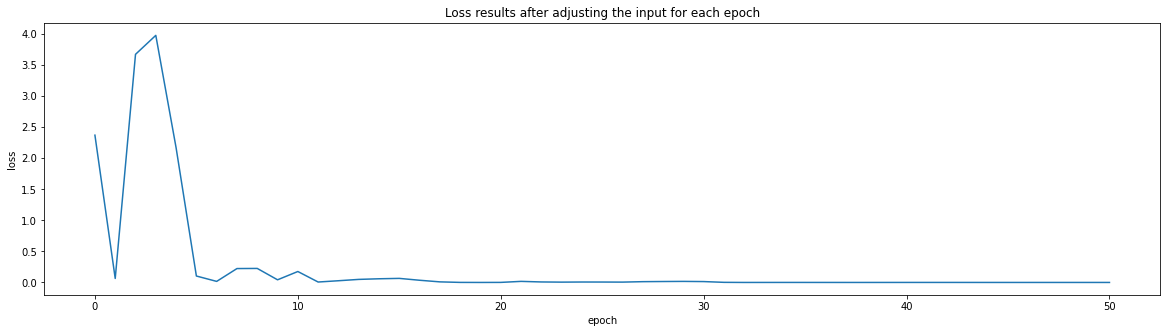

In [60]:
plt.figure(figsize=(20,5))
plt.plot(losses)
plt.title("Loss results after adjusting the input for each epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig(f"{pred_path}/loss.png")
plt.show()

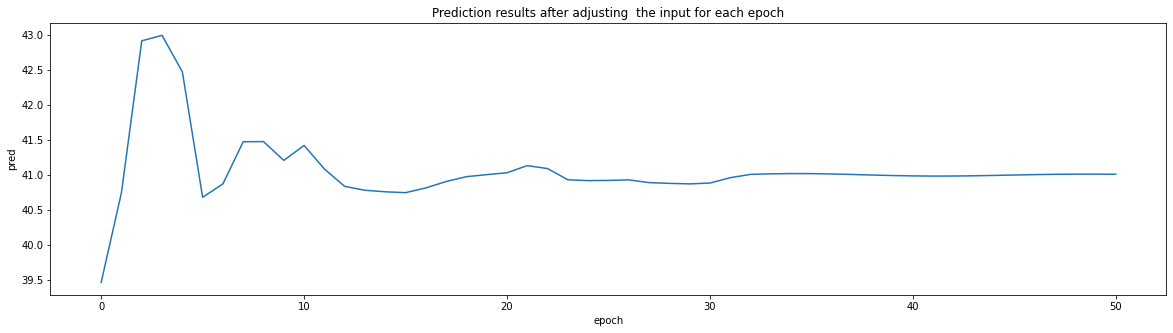

In [61]:
plt.figure(figsize=(20,5))
plt.plot(preds)
plt.title("Prediction results after adjusting  the input for each epoch")
plt.xlabel("epoch")
plt.ylabel("pred")
plt.savefig(f"{pred_path}/pred.png")
plt.show()

#### Save output

In [62]:
X = pd.DataFrame(X, columns = features, index = ["new"])
update = pd.concat([input_X, X]).T
update["fixed"] = fixed_mask
update["change"] = update.eval("(init != new)").astype(int)

# 檢測是否有不可調動的參數被調動
# update["check"] = update.eval("not ((init != new) & fixed)").astype(int)
# update["pred"] = round(pred_round1, 1)
update.reset_index(drop = True)

,init,new,fixed,change
0,-37.7,-37.70,1.0,0
1,-31.0,-31.00,1.0,0
2,-34.4,-34.40,1.0,0
3,87.0,87.31,0.0,1
4,64.9,64.55,0.0,1
5,17.1,16.83,0.0,1
6,10.0,10.00,1.0,0
7,-35.6,-35.24,0.0,1
8,-50.3,-50.30,1.0,0
9,-42.9,-42.90,1.0,0


In [63]:
update = update.T.to_dict()
update[target] = {"init": target1, "new": pred_round1}
update["status"] = "success"
update["reason"] = ""
with open(output_path, 'w') as f:
    json.dump(update, f)